In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from math import atan2
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_motion_CoM_acceleration
%store -r Y_motion_CoM_acceleration
%store -r X_motion_CoM_continuous
%store -r Y_motion_CoM_continuous

X_motion_CoM = np.vstack((X_motion_CoM_acceleration, X_motion_CoM_continuous))
Y_motion_CoM = np.vstack((Y_motion_CoM_acceleration, Y_motion_CoM_continuous))
print(X_motion_CoM.shape)
print(Y_motion_CoM.shape)

(3486, 35)
(3486, 3)


# Multivariate Linear Regression (CoM Prediction)

In [6]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [7]:
X_motion_CoM.shape

(3486, 35)

In [8]:
idx_fr_rl_swinging = np.where(X_motion_CoM[:, -1] == 1)[0]
X_motion_CoM_FR_RL = X_motion_CoM[idx_fr_rl_swinging]
Y_motion_CoM_FR_RL = Y_motion_CoM[idx_fr_rl_swinging]
print(X_motion_CoM_FR_RL.shape)
print(Y_motion_CoM_FR_RL.shape)

(1746, 35)
(1746, 3)


## Predict CoM (x) movement

In [9]:
X_motion_CoM_FR_RL[0, :3]

array([0.1, 0.0, 0.0], dtype=object)

In [10]:
Y_motion_CoM_FR_RL[0, :]

array([0.03393453653348999, 0.0027370063851639426, 0.003373050826489625],
      dtype=object)

### Linear Regression

In [11]:
# Input
X = np.hstack((X_motion_CoM_FR_RL[:, :3], # Previous motion command
               X_motion_CoM_FR_RL[:, -5:-2], # Current motion command
               X_motion_CoM_FR_RL[:, 3:5], # FL (x,y) position
               X_motion_CoM_FR_RL[:, 6:8], # FR (x,y) position
               X_motion_CoM_FR_RL[:, 9:11], # RL (x,y) position
               X_motion_CoM_FR_RL[:, 12:14])) # RR (x, y) position
               
# Labels
Y = np.array([Y_motion_CoM_FR_RL[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fr_com_x = LinearRegression()

# Fit the model
model_fr_com_x.fit(X_train, Y_train)

# Predict
predictions = model_fr_com_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9680229005251435
RMSE:  0.013162691269890671
The lowest error is:  1.6695484742618172e-05
The highest error is:  0.06866680116524884
The avg. error is:  0.00819594057171617


In [12]:
model_fr_com_x.coef_

array([[ 1.27608154e-01,  1.40627616e+09,  5.87919846e+12,
         9.35323238e-02, -9.17424075e+09, -5.87919846e+12,
         1.64172649e-01,  6.04940310e-01,  7.19354898e-02,
        -3.15462530e-01,  1.96177810e-02, -7.62230754e-02,
         2.44806409e-02, -2.69220147e-01]])

In [13]:
model_fr_com_x.intercept_

array([-0.19123681])

In [14]:
input_ = np.array([[0.0,0.0,0.0,0.1,0.0,0.0, 0.237936324231, 0.188065700274, 0.234281409653, -0.171743092874, -0.249921495098, 0.161507381121, -0.259071586366, -0.138188475913]])
output = input_ @ model_fr_com_x.coef_.T + model_fr_com_x.intercept_
print(output)

[[0.05562662]]


Text(0, 0.5, 'Predictions')

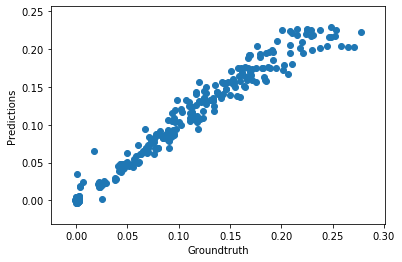

In [15]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [16]:
#for idx, prediction in enumerate(predictions):
#    print(f'Command: {X_test[idx, :3]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

## Predict CoM -> y

### Linear Regression

In [17]:
# Input
X = np.hstack((X_motion_CoM_FR_RL[:, :3], # Previous motion command
               X_motion_CoM_FR_RL[:, -5:-2], # Current motion command
               X_motion_CoM_FR_RL[:, 3:5], # FL (x,y) position
               X_motion_CoM_FR_RL[:, 6:8], # FR (x,y) position
               X_motion_CoM_FR_RL[:, 9:11], # RL (x,y) position
               X_motion_CoM_FR_RL[:, 12:14])) # RR (x, y) position

# Labels
Y = np.array([Y_motion_CoM_FR_RL[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fr_com_y = LinearRegression()

# Fit the model
model_fr_com_y.fit(X_train, Y_train)

# Predict
predictions = model_fr_com_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.7789548709990733
RMSE:  0.0034526249928520567
The lowest error is:  1.6889811785839037e-05
The highest error is:  0.035327692738900976
The avg. error is:  0.0024085614250104366


In [18]:
model_fr_com_y.coef_

array([[ 8.33200803e-03,  1.37896532e+08,  5.76502043e+11,
         3.08222622e-02, -8.99607075e+08, -5.76502043e+11,
        -1.22493770e-01,  9.45340525e-02, -2.29250910e-02,
        -2.58467495e-02,  1.09096943e-01, -1.95437263e-01,
        -6.64886460e-03,  2.13660796e-01]])

In [19]:
model_fr_com_y.intercept_

array([0.09964802])

Text(0, 0.5, 'Predictions')

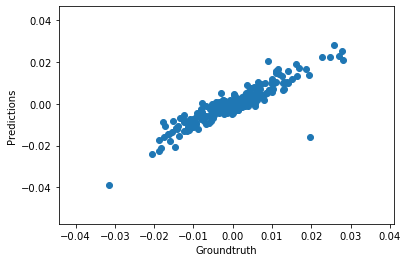

In [20]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [21]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

## Predict CoM -> Yaw

In [22]:
# Input
X = np.hstack((X_motion_CoM_FR_RL[:, :3], # Previous motion command
               X_motion_CoM_FR_RL[:, -5:-2], # Current motion command
               X_motion_CoM_FR_RL[:, 3:5], # FL (x,y) position
               X_motion_CoM_FR_RL[:, 6:8], # FR (x,y) position
               X_motion_CoM_FR_RL[:, 9:11], # RL (x,y) position
               X_motion_CoM_FR_RL[:, 12:14])) # RR (x, y) position

# Labels
Y = np.array([Y_motion_CoM_FR_RL[:, 2]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fl_com_theta = LinearRegression()

# Fit the model
model_fl_com_theta.fit(X_train, Y_train)

# Predict
predictions = model_fl_com_theta.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9881575812833114
RMSE:  0.009680110526841744
The lowest error is:  3.876194697188806e-05
The highest error is:  0.06591817819515638
The avg. error is:  0.004930882667194544


In [23]:
model_fl_com_theta.coef_

array([[-4.82120047e-03, -1.15547983e+08, -4.83069789e+11,
         6.69462979e-03,  7.53809991e+08,  4.83069789e+11,
         5.79082515e-01, -5.28907365e-01, -3.57574810e-01,
        -5.57573666e-01,  4.69077374e-01,  5.97462879e-01,
        -5.62740196e-01,  4.99864754e-01]])

In [24]:
model_fl_com_theta.intercept_

array([-0.0921434])

Text(0, 0.5, 'Predictions')

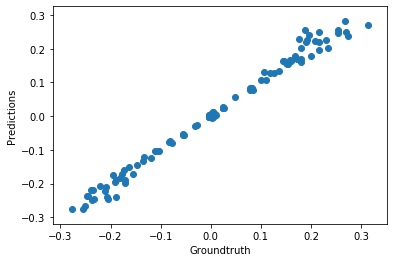

In [25]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")